 # Reducing Astronomical Images

In this notebook, we study the properties of astronomical images captured from a telescope.   These images have artifacts due the the instrument that need to be removed through calibration.  These images also contain sources of light (i.e., stars and galaxies) as well as noise.  

We will utilize the numpy package for data analysis.  We will use the matplotlib package to display data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's begin by grabbing some real data and making a plot.

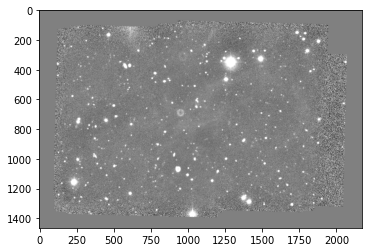

In [2]:
from astropy.io.fits import getdata
dat = getdata('stack_C1_i.fits')
plt.imshow(dat.clip(-8.3,8.3),cmap='gray')

The image above is an actual image captured by the <A HREF="http://ratir.astroscu.unam.mx"> RATIR </A> telescope.  There are stars, which appear large when brighter.  This is not because they are physically larger; it is because the signal is spread out over more pixels before it becomes smaller than the background noise level.  The background noise are the speckles you can see in the image.  There is also noise due to calibration errors (i.e., smudge-like artifacts).

In [3]:
print (type(dat))
print (dat)

<class 'numpy.ndarray'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


The astropy library is used to read the image from disk.  As you can see from the previous commands, the data are stored in a two-dimensional numpy array.

## Simulating Telescope Images

We will now use a simple telescope simulator to generate raw telescope images.  This version returns simulated images AND the "data" used to generate them.  For the labs, you will not have access to the generating data.  You will have to solve for that.  Use the help command to see how the simulator works:

In [4]:
from simulate_image import imsim
help(imsim)

Help on function imsim in module simulate_image:

imsim(sigma=2.0, RN=10.0, sky_lev=1000.0, add_stars=True, calibrated=True, verbose=False)
    generate astronomical images, potentially with stars (add_stars=True)
    
    calibrated=False means image is uncorrected for flat and dark, to estimate these:
      bias images: set sky_lev=0.,add_stars=False
      flat images: set sky_lev large, add_stars=False
    
    sigma: rms width of stars in pixels
    RN: rms read noise
    sky_lev: sky background counts level



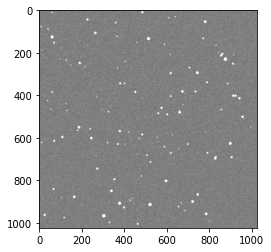

In [5]:
im,data = imsim()
im -= np.median(im)  #  subtract the sky background
rms = 1.48*np.median(np.abs(im))
plt.imshow(im.clip(-5*rms,5*rms),cmap='gray')

Without any arguments, the simulator creates a calibrated image with a number of stars.  The background clip method is used to scale the image to best see the stars.  The parameters are the low and high pixel values to display.  These are determined by estimating the rms (root-mean-square) noise in the background of the image.

Let's look at an image which has not yet been calibrated.  It looks terrible as compared to the previous image.  

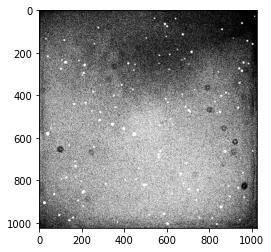

In [6]:
im, data = imsim(calibrated=False)
im -= np.median(im)
plt.imshow(im.clip(-rms,rms),cmap='gray')

There are two types of calibrations we will need to employ.  

We will need to estimate the "bias" in the detector.  This is the signal present when no light reaches the instrument.  The detector pixels themselves have structure and noise.

We will also need to estimate the flat-field response of the instrument.  This the hazy looking structure show in the image above.  It is there because a varying amount of light is allowed to reach different pixels from the telescope, and each pixel has a different sensitivity to light.

Let's start by estimating the detector bias by capturing 10 images with sky level of zero and then combining those with the median operation.

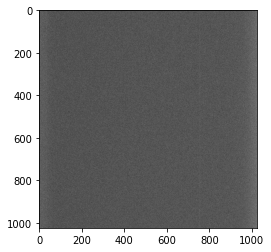

In [7]:
dat = []
for i in range(10):
    im = imsim(calibrated=False,add_stars=False,sky_lev=0)
    dat.append(im)
    
bias = np.median(dat,axis=0)
plt.imshow(bias,cmap='gray')

The axis=0 argument supplied to the median function calculates the median over the first dimension only of dat.  This allows us to calculate the median of every pixel in a series of images.

Now let's create a flat field image.  This is typically done by taking an exposure of the bright sky just after sunset or before sunrise or an exposure of the inside of the telescope dome.  Again, if we capture 10 of these, subtract away the bias (just determined) each time and normalize each to a median of 1, we can build a flat-frame image.

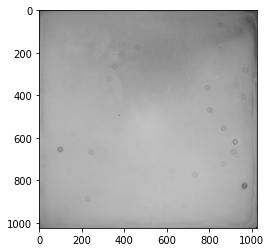

In [8]:
dat = []
for i in range(10):
    im = imsim(calibrated=False,add_stars=False,sky_lev=4.e4) - bias
    dat.append( im/np.median(im) )
    
flat = np.median(dat,axis=0)
flat[flat<0.8]=0.8

plt.imshow(np.log(flat),cmap='gray')

Notice that we again create a list of images, subtracting our bias estimate from each and normalizing each by its own median.

We also make sure, by doing flat[flat<0.8]=0.8, that the resulting flat field image has no values smaller than 0.8 (typical value is 1.0).

Finally, let's generate a science image, apply the bias and flat, and see how it looks.

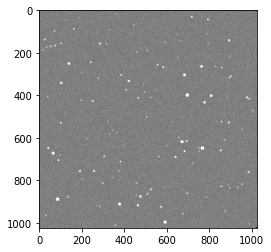

In [9]:
im, data = imsim(calibrated=False)
im -= bias # bias correction
im /= flat # flat field correction
im -= np.median(im) # background subtraction
plt.imshow(im.clip(-5*rms,5*rms),cmap='gray')

That looks nice and clean.

In the notebooks that follow, we will assume the default parameter calibrated=True in the function imsim().  That is, the detector bias and detector/telescope flat-field corrections have already been made.

Finally, let's cleanup.

In [10]:
im = 0
bias = 0
flat = 0
dat = []